## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Tue May 23 11:35:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install YOLO-NAS


In [5]:
!pip install -q super-gradients==3.1.1
!pip install -q roboflow
!pip install -q supervision

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.0.9 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.1.1 requires pyparsing==2.4.5, but you have pyparsing 2.4.7 which is incompatible.


### 🚨 Restart the runtime

**After installation is complete, you'll need to restart the runtime after installation completes. Navigate to `Runtime` -> `Restart runtime` and confirm by clicking `Yes` when you see the popup.**

After that, carry on with the notebook starting from the cell below 👇

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'

In [3]:
from super_gradients.training import models

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

The console stream is logged into /root/sg_logs/console.log


[2023-05-23 11:36:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-23 11:36:33] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-23 11:36:33] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-23 11:36:33] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-23 11:36:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-23 11:36:35] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with thes

### Use Example Data (Below, We'll Prepare Our Own Custom Dataset)

Let's download few example images. Feel free to replace my images with yours. All you have to do is upload them to the `{HOME}/data` directory. If you're looking for data, take a peek at [Roboflow Universe](https://universe.roboflow.com/)! You're sure to find something interesting.

In [4]:
f"{HOME}/data"

'/content/data'

In [5]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

/content
/content/data


In [14]:
!wget -q https://purpleavocado.de/wp-content/uploads/2018/05/kebap-doogh_MG_7959.jpg

### Single Image Inference

In [5]:
SOURCE_IMAGE_PATH = f"{HOME}/data/IMG-20191212-WA0007.jpg"

In [6]:
import cv2

image = cv2.imread(SOURCE_IMAGE_PATH)
result = list(model.predict(image, conf=0.35))[0]

### Output format

For every image YOLO-NAS will produce `ImageDetectionPrediction` object containing the following fields:
- `image` - `numpy.ndarray` - image used for inference
- `class_names` - `List[str]` - list of categories used for training the model
- `prediction` - `DetectionPrediction` - class instance containing detailed informationabout the obtained detections
   - `bboxes_xyxy` - `numpy.ndarray` of `float32` and `(N, 4)` shape - detection bounding boxes in `xyxy` format 
   - `confidence` - `numpy.ndarray` of `float32` and `(N,)` shape - confidence value between `0` and `1`
   - `labels` - `numpy.ndarray` of `float32` and `(N,)` shape - `class_id` related to the index in the `class_names` list

In [7]:
type(result)

super_gradients.training.models.prediction_results.ImageDetectionPrediction

### Visualize Inference Result

As with other models, you can use Supervision to visualize your results. You can read more about the integration between Supervision and YOLO-NAS [here](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_yolo_nas), and about visualizing detection [here](https://roboflow.github.io/supervision/detection/annotate/#supervision.detection.annotate.BoxAnnotator.annotate).

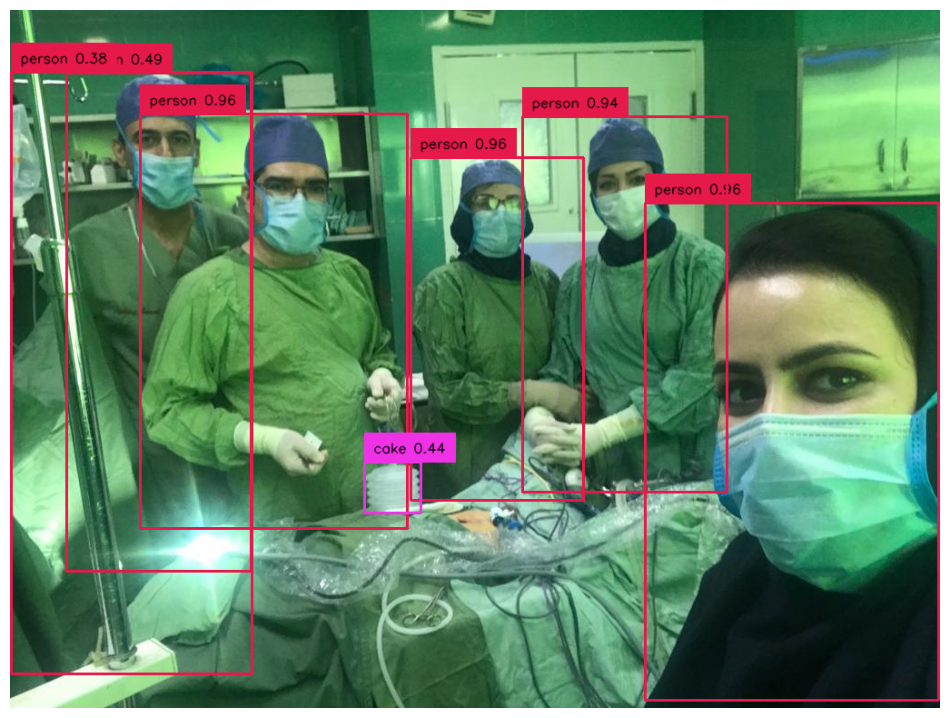

In [8]:
import supervision as sv

detections = sv.Detections(
    xyxy=result.prediction.bboxes_xyxy,
    confidence=result.prediction.confidence,
    class_id=result.prediction.labels.astype(int)
)

box_annotator = sv.BoxAnnotator()

labels = [
    f"{result.class_names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (12, 12))